<a href="https://colab.research.google.com/github/YunusTamboli/Gen-AI/blob/main/Deepconv_gan8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Path to dataset files: /root/.cache/kagglehub/datasets/yunting0123/img-align-celeba/versions/1
t


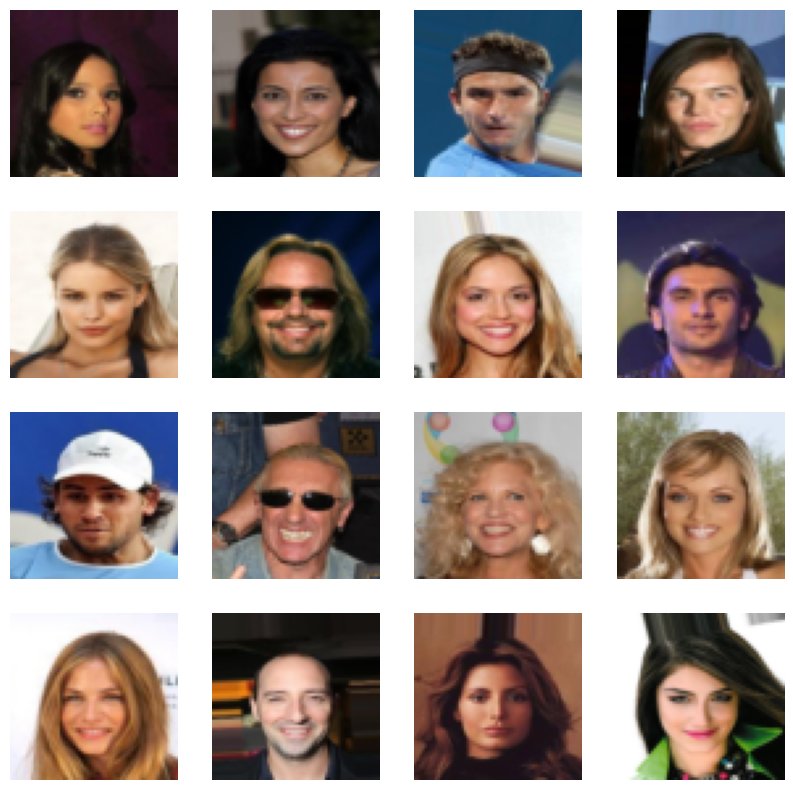

Epoch [0/50], Step [0/1875], D Loss: 0.6759741902351379, G Loss: 10.511394500732422
Epoch [0/50], Step [100/1875], D Loss: 0.562940776348114, G Loss: 4.193458557128906
Epoch [0/50], Step [200/1875], D Loss: 0.609576940536499, G Loss: 2.6551332473754883
Epoch [0/50], Step [300/1875], D Loss: 0.5355916023254395, G Loss: 1.846856713294983
Epoch [0/50], Step [400/1875], D Loss: 0.5356153845787048, G Loss: 2.4264070987701416
Epoch [0/50], Step [500/1875], D Loss: 0.6241845488548279, G Loss: 3.210449695587158
Epoch [0/50], Step [600/1875], D Loss: 0.39765557646751404, G Loss: 4.136844158172607


In [ ]:
import kagglehub
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
# Download latest version
path = kagglehub.dataset_download("yunting0123/img-align-celeba")
print("Path to dataset files:", path)
# Install dependencies
!pip install torch torchvision matplotlib
# Check the files
!ls /root/.cache/kagglehub/datasets/yunting0123/img-align-celeba/versions/1
# Hyperparameters
image_size = 64  # Image size (CelebA images are 178x178, but we will resize them)
batch_size = 128
z_dim = 100  # Latent vector size
num_epochs = 50
lr = 0.0002  # Learning rate
beta1 = 0.5  # Adam optimizer parameter
# Data transformations
transform = transforms.Compose([
    transforms.Resize(image_size),  # Resize images to 64x64
    transforms.CenterCrop(image_size),  # Crop the image at the center
    transforms.ToTensor(),  # Convert to Tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])
# Dataset and DataLoader
dataset = datasets.ImageFolder(root='/root/.cache/kagglehub/datasets/yunting0123/img-align-celeba/versions/1', transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
# Generator Model
class Generator(nn.Module):
    def __init__(self, z_dim):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 1024, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),
            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()  # Output: 3 x 64 x 64 (RGB image)
        )
    def forward(self, z):
        return self.main(z)
# Discriminator Model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(1024, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()  # Output: 1 x 1 x 1 (probability)
        )
    def forward(self, x):
        return self.main(x)
# Loss function
adversarial_loss = nn.BCELoss()
# Initialize models
generator = Generator(z_dim)
discriminator = Discriminator()
# Move models to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator.to(device)
discriminator.to(device)
# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
# Training function
# Training function
# Training function
def train():
    for epoch in range(num_epochs):
        for i, (imgs, _) in enumerate(dataloader):
            imgs = imgs.to(device)

            # Labels for real and fake images
            real_labels = torch.ones(imgs.size(0), 1).to(device)
            fake_labels = torch.zeros(imgs.size(0), 1).to(device)

            # Train Discriminator
            optimizer_D.zero_grad()
            # Real images
            real_loss = adversarial_loss(discriminator(imgs).view(-1, 1), real_labels)
            real_loss.backward()

            # Fake images
            z = torch.randn(imgs.size(0), z_dim, 1, 1).to(device)
            fake_imgs = generator(z)
            fake_loss = adversarial_loss(discriminator(fake_imgs.detach()).view(-1, 1), fake_labels)
            fake_loss.backward()

            # Total discriminator loss
            d_loss = (real_loss + fake_loss) / 2
            optimizer_D.step()

            # Train Generator
            optimizer_G.zero_grad()
            # Generator loss (try to fool the discriminator)
            # Reshape the output to match real_labels shape
            g_loss = adversarial_loss(discriminator(fake_imgs).view(-1, 1), real_labels)
            g_loss.backward()
            optimizer_G.step()

            if i % 100 == 0:
                print(f"Epoch [{epoch}/{num_epochs}], Step [{i}/{len(dataloader)}], "
                      f"D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")

        if epoch % 5 == 0:
            with torch.no_grad():
                z = torch.randn(16, z_dim, 1, 1).to(device)
                generated_images = generator(z)
                save_image(generated_images, f"celeba_generated_epoch_{epoch}.png", nrow=4, normalize=True)

# Show generated images after training
def show_generated_images(epoch):
    with torch.no_grad():
        z = torch.randn(16, z_dim, 1, 1).to(device)
        generated_images = generator(z)
        save_image(generated_images, f"generated_images_epoch_{epoch}.png", nrow=4, normalize=True)
# Display some real images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# Data loading and transformation
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
dataset = datasets.ImageFolder(root='/root/.cache/kagglehub/datasets/yunting0123/img-align-celeba/versions/1', transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)  # Batch size of 16 for display
# Display images
dataiter = iter(dataloader)
images, labels = next(dataiter)
fig, axes = plt.subplots(4, 4, figsize=(10, 10))  # Create a 4x4 grid of subplots
for j, ax in enumerate(axes.flat):
    img = images[j].cpu().numpy().transpose(1, 2, 0)  # Move to CPU and reshape
    img = (img + 1) / 2  # Denormalize
    ax.imshow(img)
    ax.axis('off')
plt.show()
# Run the training
train()